In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from keras.models import Sequential,Model
from keras.layers import AveragePooling2D,Conv2D,Dropout,Flatten,BatchNormalization,LeakyReLU,Dense,Activation,UpSampling2D,Conv2DTranspose,MaxPooling2D,concatenate
from keras.losses import binary_crossentropy
from keras.optimizers import *
from keras import Input

Using TensorFlow backend.


In [0]:
import imgaug as ia
from imgaug import augmenters as iaa
ia.seed(4)

In [0]:
x  = np.load('/content/drive/My Drive/Unet_correctness/dataset/image_train.npz')
y = np.load('/content/drive/My Drive/Unet_correctness/dataset/label_train.npz')
x = x['image_train']
y = y['label_train']

In [0]:
x_256 = iaa.Resize((256,256))(images = (x * 255).astype('uint8'))
y_256 = iaa.Resize((256,256))(images = y)
x_256 = x_256/255
gamma = iaa.GammaContrast(1.25)(images = x_256)
log = iaa.LogContrast(0.9)(images = x_256)
sigmoid = iaa.SigmoidContrast(4)(images = x_256)
big_x = np.vstack([x_256,gamma,log,sigmoid])
big_y = np.vstack([y_256,  y_256   , y_256     ,y_256])

In [0]:
x_train, x_test, y_train, y_test = train_test_split(big_x, big_y, test_size = 0.2, random_state = 103)
x_train = np.reshape(x_train,(307,256,256,1))
x_test = np.reshape(x_test,(77,256,256,1))
y_train = np.reshape(y_train,(307,256,256,1))
y_test = np.reshape(y_test,(77,256,256,1))

In [0]:
def generator(input_shape):
  
  conv_1 = Conv2D(filters = 32,kernel_size=(3,3),strides = 1,padding = 'same',kernel_initializer='he_normal')(input_shape)
  batch_conv1 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(conv_1)
  activate_batch_conv1 = Activation('relu')(batch_conv1)

  conv_2 = Conv2D(filters = 32,kernel_size = (3,3),strides = 1,padding = 'same',kernel_initializer = 'he_normal')(activate_batch_conv1)
  batch_conv2 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(conv_2)
  activate_batch_conv2 = Activation('relu')(batch_conv2)
  
  
  ######### POOL_Start
  pool_1 = MaxPooling2D(pool_size = (2,2),strides= (2,2))(activate_batch_conv2)
  pool_1 = Dropout(0.025)(pool_1)  
  ######### Pool_End
  
  
  conv_3 = Conv2D(filters = 64,kernel_size = (3,3),strides = 1,padding = 'same',kernel_initializer='he_normal')(pool_1)
  batch_conv3 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(conv_3)
  activate_batch_conv3 = Activation('relu')(batch_conv3)

  conv_4 = Conv2D(filters = 64,kernel_size = (3,3),strides =1,padding = 'same',kernel_initializer='he_normal')(activate_batch_conv3)
  batch_conv4 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(conv_4)
  activate_batch_conv4 = Activation('relu')(batch_conv4)
  
  
  ######### POOL_Start
  pool_2 = MaxPooling2D(pool_size = (2,2),strides= (2,2))(activate_batch_conv4)
  pool_2 = Dropout(0.025)(pool_2)  
  ######### POOL_End
  
  
  conv_5 = Conv2D(filters = 128,kernel_size = (3,3),strides = 1,padding = 'same',kernel_initializer='he_normal')(pool_2)
  batch_conv5 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(conv_5)
  activate_batch_conv5 = Activation('relu')(batch_conv5)

  conv_6 = Conv2D(filters = 128,kernel_size = (3,3),strides = 1,padding = 'same',kernel_initializer='he_normal')(activate_batch_conv5)
  batch_conv6 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(conv_6)
  activate_batch_conv6 = Activation('relu')(batch_conv6)
  
  
  ######### POOL_Start
  pool_3 = MaxPooling2D(pool_size = (2,2),strides= (2,2))(activate_batch_conv6)
  pool_3 = Dropout(0.025)(pool_3)
  ######### POOL_End
  
  
  conv_7 = Conv2D(filters = 256,kernel_size = (3,3),strides = 1,padding = 'same',kernel_initializer='he_normal')(pool_3)
  batch_conv7 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(conv_7)
  activate_batch_conv7 = Activation('relu')(batch_conv7)

  conv_8 = Conv2D(filters = 256,kernel_size = (3,3),strides = 1,padding = 'same',kernel_initializer='he_normal')(activate_batch_conv7)
  batch_conv8 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(conv_8)
  activate_batch_conv8 = Activation('relu')(batch_conv8)
  
  
  #########  POOL
  pool_4 = MaxPooling2D(pool_size = (2,2),strides= (2,2))(activate_batch_conv8)
  pool_4 = Dropout(0.025)(pool_4)
  #########  POOL
  
  
  conv_9 = Conv2D(filters = 512,kernel_size = (3,3),strides = 1,padding = 'same',kernel_initializer='he_normal')(pool_4)
  batch_conv9 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(conv_9)
  activate_batch_conv9 = Activation('relu')(batch_conv9)

  conv_10 = Conv2D(filters = 512,kernel_size = (3,3),strides = 1,padding = 'same',kernel_initializer='he_normal')(activate_batch_conv9)
  batch_conv10 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(conv_10)
  activate_batch_conv10 = Activation('relu')(batch_conv10)
  
  
  ################Upsample-1 Start
  
  up1 = UpSampling2D(size = (2,2),interpolation = 'bilinear')(activate_batch_conv10)
  up1_conv = Conv2D(filters = 256,kernel_size = (3,3),strides = 1,padding = 'same',kernel_initializer='he_normal')(up1)
  merge_up1 = concatenate([activate_batch_conv8,up1_conv])
  drop_up1 = Dropout(0.025)(merge_up1)
  
  conv_11 = Conv2D(filters = 256,kernel_size = (3,3),strides = 1,padding = 'same',kernel_initializer='he_normal')(drop_up1)
  batch_conv11 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(conv_11)
  activate_batch_conv11 = Activation('relu')(batch_conv11)
  
  conv_12 = Conv2D(filters = 256,kernel_size = (3,3),strides = 1,padding = 'same',kernel_initializer='he_normal')(activate_batch_conv11)
  batch_conv12 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(conv_12)
  activate_batch_conv12 = Activation('relu')(batch_conv12)
  
  ################Upsample-1 End
  
  
  ################Upsample-2 Start
  
  up2 = UpSampling2D(size = (2,2),interpolation = 'bilinear')(activate_batch_conv12)
  up2_conv = Conv2D(filters = 128,kernel_size = (3,3),strides = 1,padding = 'same',kernel_initializer='he_normal')(up2)
  merge_up2 = concatenate([activate_batch_conv6,up2_conv])
  drop_up2 = Dropout(0.025)(merge_up2)
  
  conv_13 = Conv2D(filters = 128,kernel_size = (3,3),strides = 1,padding = 'same',kernel_initializer='he_normal')(drop_up2)
  batch_conv13 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(conv_13)
  activate_batch_conv13 = Activation('relu')(batch_conv13)
  
  conv_14 = Conv2D(filters = 128,kernel_size = (3,3),strides = 1,padding = 'same',kernel_initializer='he_normal')(activate_batch_conv13)
  batch_conv14 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(conv_14)
  activate_batch_conv14 = Activation('relu')(batch_conv14)
  
  ################Upsample-2 End
  
  
  ################Upsample-3 Start
  
  up3 = UpSampling2D(size = (2,2),interpolation = 'bilinear')(activate_batch_conv14)
  up3_conv = Conv2D(filters = 64,kernel_size = (3,3),strides = 1,padding = 'same',kernel_initializer='he_normal')(up3)
  merge_up3 = concatenate([activate_batch_conv4,up3_conv])
  drop_up3 = Dropout(0.025)(merge_up3)
  
  conv_15 = Conv2D(filters = 64,kernel_size = (3,3),strides = 1,padding = 'same',kernel_initializer='he_normal')(drop_up3)
  batch_conv15 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(conv_15)
  activate_batch_conv15 = Activation('relu')(batch_conv15)
  
  conv_16 = Conv2D(filters = 64,kernel_size = (3,3),strides = 1,padding = 'same',kernel_initializer='he_normal')(activate_batch_conv15)
  batch_conv16 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(conv_16)
  activate_batch_conv16 = Activation('relu')(batch_conv16)

  ################Upsample-3 End
  
  
  ################Upsample-4 Start
  
  up4 = UpSampling2D(size = (2,2),interpolation = 'bilinear')(activate_batch_conv16)
  up4_conv = Conv2D(filters = 32,kernel_size = (3,3),strides = 1,padding = 'same',kernel_initializer='he_normal')(up4)
  merge_up4 = concatenate([activate_batch_conv2,up4_conv])
  drop_up4 = Dropout(0.025)(merge_up4)
  
  conv_17 = Conv2D(filters = 32,kernel_size = (3,3),strides = 1,padding = 'same',kernel_initializer='he_normal')(drop_up4)
  batch_conv17 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(conv_17)
  activate_batch_conv17 = Activation('relu')(batch_conv17)
  
  conv_18 = Conv2D(filters = 32,kernel_size = (3,3),strides = 1,padding = 'same',kernel_initializer='he_normal')(activate_batch_conv17)
  batch_conv18 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(conv_18)
  activate_batch_conv18 = Activation('relu')(batch_conv18)
  
  conv_19 = Conv2D(filters = 2,kernel_size = (3,3),strides = 1,activation = 'relu',padding = 'same',kernel_initializer='he_normal')(activate_batch_conv18)
  conv_20 = Conv2D(filters = 1,kernel_size = (1,1),strides = 1,activation = 'sigmoid',padding = 'same',kernel_initializer='he_normal')(conv_19)

  ################Upsample-4 End
  model_gen = Model(input = [input_shape], output =[conv_20])
  return model_gen

In [0]:
def discriminator(input_img_shape):
  input_img = Input(input_img_shape)
  image_from_gen_or_label = Input(input_img_shape)
  mix = concatenate([input_img,image_from_gen_or_label])
  
  disc_conv1 = Conv2D(filters = 64,kernel_size=(3,3),strides = 1,padding='same',kernel_initializer='he_normal')(mix)
  disc_conv1_leaky = LeakyReLU(alpha=0.2)(disc_conv1)
  
  
  disc_conv2 = Conv2D(filters = 128,kernel_size=(3,3),strides = 1,padding='same',kernel_initializer='he_normal')(disc_conv1_leaky)
  disc_conv2_batch = BatchNormalization()(disc_conv2)
  disc_conv2_leaky = LeakyReLU(alpha=0.2)(disc_conv2_batch)
  
  
  
  disc_conv3 = Conv2D(filters = 256,kernel_size=(3,3),strides = 1,padding='same',kernel_initializer='he_normal')(disc_conv2_leaky)
  disc_conv3_batch = BatchNormalization()(disc_conv3)
  disc_conv3_leaky = LeakyReLU(alpha=0.2)(disc_conv3_batch)
  
  
  
  disc_conv4 = Conv2D(filters = 512,kernel_size=(3,3),strides = 1,padding='same',kernel_initializer='he_normal')(disc_conv3_leaky)
  disc_conv4_batch = BatchNormalization()(disc_conv4)
  disc_conv4_leaky = LeakyReLU(alpha=0.2)(disc_conv4_batch)
  
  disc_conv_5 = Conv2D(filters = 1,kernel_size = (1,1),strides = 1,activation = 'sigmoid',padding = 'same',kernel_initializer='he_normal')(disc_conv4_leaky)
  
  model_disc = Model(input = [input_img,image_from_gen_or_label],output = [disc_conv_5])
  return model_disc

In [0]:
def gan(generator_model, discriminator_model):
  discriminator_model.trainable = False
  input_img = Input((256,256,1))
  
  g = generator_model(input_img)
  d = discriminator_model([input_img, g])
  
  model_gan = Model(input_img, [d, g])
 
  return model_gan

In [0]:
def select_real_fake(generator,X_train,y_train,n_samples):
  index = np.random.randint(0, X_train.shape[0], n_samples)
   
  index = np.random.randint(0, X_train.shape[0], n_samples)
  X_A,X_B = X_train[index],y_train[index]
  y_1 = np.ones((n_samples,256,256,1))
  
  X_C = generator.predict(X_A)    #predict
  y_2 = np.zeros((n_samples,256,256,1)) 
  
  
  return [X_A , X_B] , y_1 , X_C , y_2

In [0]:
def train_model(generator,discriminator,gan_new,X_train,y_train,batch,epoch):
  iterations = int(X_train.shape[0] / batch)
  cust = Adam(lr=0.0004, beta_1=0.5)
  discriminator.compile(loss='binary_crossentropy', optimizer=cust, metrics=['accuracy'])
  gan_new.compile(loss=['binary_crossentropy','binary_crossentropy'],optimizer = Adam(lr=0.0002, beta_1=0.5))
  beat = 0
  for i in range(epoch):
    for j in range(iterations):
      
      [X_real1,X_real2],y_real,X_fake,y_fake = select_real_fake(generator,X_train,y_train,batch)
      #print(X_real1.shape,X_real2.shape)
      discriminator.trainable = True
      #print(y_real.shape)
      discriminator.train_on_batch([X_real1,X_real2],y_real)
      d_loss = discriminator.train_on_batch([X_real1,X_fake],y_fake)
      discriminator.trainable = False
      gan_loss,_,_ = gan_new.train_on_batch(X_real1, [y_real, X_real2])
      
    print(d_loss,gan_loss)
    iou_list = []
    for kl in range(x_test.shape[0]):
      jk = generator.predict(x_test[kl].reshape(1,256,256,1))
      img = jk.copy()
      img[jk< 0.1] = 0
      img[jk >= 0.1] = 1
      intersection = np.logical_and(img.reshape(256,256), y_test[kl].reshape(256,256))
      union = np.logical_or(img.reshape(256,256), y_test[kl].reshape(256,256))
      iou_score = np.sum(intersection) / np.sum(union)
      iou_list.append(iou_score)
    #if(beat % 5 == 0):
    #  generator.save('gen_'+str(beat)+'.h5')
    #beat = beat+1
    print('%d epoch iou is %f: '%(i+1,np.mean(iou_list)))
  return generator

In [12]:
gf = generator((Input((256,256,1))))
df = discriminator((256,256,1))
ganf = gan(gf,df)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:145: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [13]:
my_model = train_model(gf, df, ganf,x_train,y_train,8,100)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



[0.5844213, 0.69119644] 1.3948288
1 epoch iou is 0.764927: 
[0.5913405, 0.6779442] 1.296766
2 epoch iou is 0.774048: 
[0.593053, 0.67739296] 1.2439326
3 epoch iou is 0.766225: 
[0.5929569, 0.6774063] 1.2045684
4 epoch iou is 0.783690: 
[0.59557176, 0.6712589] 1.1988472
5 epoch iou is 0.789277: 
[0.59546006, 0.67214394] 1.1706018
6 epoch iou is 0.818584: 
[0.5991846, 0.6663151] 1.1663992
7 epoch iou is 0.825748: 
[0.5995303, 0.6709137] 1.1456051
8 epoch iou is 0.820231: 
[0.5994672, 0.66685295] 1.1504279
9 epoch iou is 0.849520: 
[0.60148287, 0.6622505] 1.1309309
10 epoch iou is 0.855597: 
[0.60055524, 0.66407967] 1.136807
11 epoch iou is 0.840196: 
[0.6020496, 0.6645813] 1.1208034
12 epoch iou is 0.878448: 
[0.6020497, 0.66423607] 1.1258131
13 epoch iou is 0.846822: 
[0.60196555, 0.6652756] 1.11573
14 epoch iou is 0.867135: 
[0.60237974, 0.6634178] 1.115667
15 epoch iou is 0.865448: 
[0.6041182, 0.66044426] 1.1195621
16 epoch iou is 0.864018: 
[0.60325336, 0.6621895] 1.1091342
17 epoc

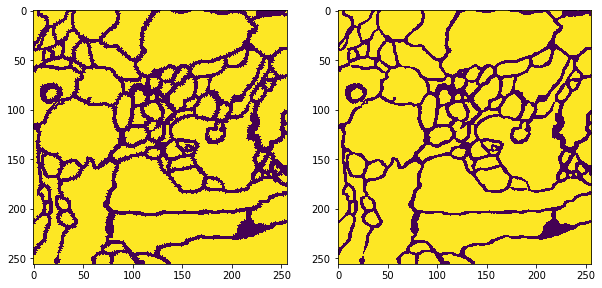

In [20]:
test_x = my_model.predict(x_test[55].reshape(1,256,256,1))

test_x_thresh = test_x.copy()
test_x_thresh[test_x >= 0.1] = 1
test_x_thresh[test_x < 0.1] = 0

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(y_test[55].reshape(256,256)) #actual
ax[1].imshow(test_x_thresh.reshape(256,256))     #predicted

In [0]:
def calc_iou(real,pred):
  num = np.logical_and(real,pred)
  den = np.logical_or(real,pred)
  
  return np.sum(num) / np.sum(den)

In [0]:
iou_train = []
for i,j in zip(x_train,y_train):
  
  dummy = my_model.predict(i.reshape(1,256,256,1))
  img = dummy.copy()
  img[dummy< 0.1] = 0
  img[dummy >= 0.1] = 1
  iou_train.append(calc_iou(j.reshape(256,256),img.reshape(256,256)))

In [0]:
iou_test = []
for i,j in zip(x_test,y_test):
  
  dummy = my_model.predict(i.reshape(1,256,256,1))
  img = dummy.copy()
  img[dummy< 0.1] = 0
  img[dummy >= 0.1] = 1
  iou_test.append(calc_iou(j.reshape(256,256),img.reshape(256,256)))

In [18]:
print("Mean IOU on training data %f"%(np.mean(np.array(iou_train))))
print("Mean IOU on test data %f"%(np.mean(np.array(iou_test))))

Mean IOU on training data 0.936175
Mean IOU on test data 0.931073


In [0]:
my_model.save('/content/drive/My Drive/Unet_correctness/GanSegmentNew.h5')